In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade numpy
!pip install --upgrade pandas


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import numpy as np
import tensorflow.keras.utils as ku

# Configuring TensorFlow session to use multiple cores
threads_num = 32  # Set this to the number of CPU cores
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=threads_num,
                                  inter_op_parallelism_threads=threads_num)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# [Rest of your code remains the same]


In [7]:
import numpy as np

In [8]:
# Open a text file in read mode
with open('hindi_poem_cleaned.txt', 'r') as file:
    content = file.read()
type(content)


str

In [9]:
tokenizer = Tokenizer()
data = content
corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [10]:
test_portion = 0.3
training_size = len(predictors)

split = int(test_portion * training_size)

#Train Validation split
valid_sequences = predictors[0:split]
training_sequences = predictors[split:training_size]
valid_labels = label[0:split]
training_labels = label[split:training_size]

print(valid_sequences.shape)
print(valid_labels.shape)

(90542, 18)
(90542, 18594)


In [11]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
#model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.save("./my_model")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 100)           1859400   
_________________________________________________________________
bidirectional (Bidirectional (None, 18, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 18, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 18594)             1877994   
Total params: 4,198,994
Trainable params: 4,198,994
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied autom

In [12]:
history = model.fit(training_sequences, training_labels, epochs=25,
                    validation_data=(valid_sequences, valid_labels),
                    verbose=1)

Epoch 1/25
6603/6603 [==============================] - 319s 48ms/step - loss: 6.9921 - accuracy: 0.0477 - val_loss: 6.9663 - val_accuracy: 0.0583
Epoch 2/25
6603/6603 [==============================] - 314s 48ms/step - loss: 6.4458 - accuracy: 0.0732 - val_loss: 6.9275 - val_accuracy: 0.0738
Epoch 3/25
2898/6603 [============>.................] - ETA: 2:31 - loss: 6.1038 - accuracy: 0.0870

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6603/6603 [==============================] - 314s 48ms/step - loss: 6.0891 - accuracy: 0.0906 - val_loss: 6.9601 - val_accuracy: 0.0806
Epoch 4/25
6603/6603 [==============================] - 315s 48ms/step - loss: 5.7636 - accuracy: 0.1080 - val_loss: 7.0437 - val_accuracy: 0.0847
Epoch 5/25
6603/6603 [==============================] - 315s 48ms/step - loss: 5.4737 - accuracy: 0.1263 - val_loss: 7.2272 - val_accuracy: 0.0874
Epoch 6/25
6603/6603 [==============================] - 314s 48ms/step - loss: 5.2312 - accuracy: 0.1431 - val_loss: 7.3362 - val_accuracy: 0.0886
Epoch 7/25
6603/6603 [==============================] - 316s 48ms/step - loss: 5.0208 - accuracy: 0.1598 - val_loss: 7.5127 - val_accuracy: 0.0880
Epoch 8/25
6603/6603 [==============================] - 313s 47ms/step - loss: 4.8359 - accuracy: 0.1767 - val_loss: 7.6669 - val_accuracy: 0.0872
Epoch 9/25
6603/6603 [==============================] - 314s 48ms/step - loss: 4.6687 - accuracy: 0.1923 - val_loss: 7.8328 - val

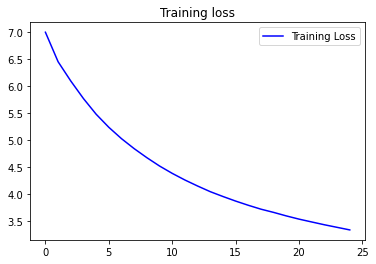

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

#plt.plot(epochs, acc, 'b', label='Training accuracy')
#plt.title('Training accuracy')
#plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation accuracy')
#plt.title('Validation accuracy')


plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
#plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
#plt.title('Validation loss')
plt.legend()

plt.show()

In [16]:
seed_text = "आकाश की ऊँचाई से नीचे"
next_words = 50
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
आकाश की ऊँचाई से नीचे खड़ी है तू क्या है बुरा क्या है कहने का है दीवाना क्या करूँ मैं क्या करूँ मैं क्या करूँ क्या हुआ है मुश्किल है प्यार का अंजाम है दिल में है दीवाना कौन करे कौन है मेरा कलमा कलमा कहाँ तेरी चाहत का दास्तां है तू है तू ही


In [17]:
seed_text = "तुम ही हो "
next_words = 50
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

तुम ही हो  तुम मुझे यूँ चुराए लिये जाते हैं मगर तुमको अजनबी से जुदा नहीं मुझे क्या है कहना है क्या प्यार है नहीं क्या है काम नहीं है क्या है हां नहीं है क्या कहना है वो क्या है खेला तेरा मरना जुदा होना मुश्किल है प्यार है क्या हुआ है


In [19]:
seed_text = "दोस्ती"
next_words = 50
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

दोस्ती का साया नहीं है मेरा चुनरी में है मेरा वतन भी दिल में है मेरा प्यार न हो तो मेरा दिल जाये ना क्यूँ जले ना क्यूँ परवाना मेरा नाम ना कान्हा डोलना मैं किधर रे ओ ओ ओ ओ ओ ओ ओ ओ ओ ओ ओ ओ ओ ओ
